In [1]:
import csv
import datetime
from itertools import islice


datasetDir = 'FileLogGenerator\\'
GenTimeFormat = '%m/%d/%Y %H:%M:%S.%f'

f = open(datasetDir+'fileLog2.csv', 'r',encoding='utf-8')
fileData = csv.reader(f)

headers = next(fileData, None)
print(headers)

GenUserActs = {}
count = 0
for row in fileData:
    if not row[4]:
        
        actTime = row[1]
        act = row[2]
        user = row[5]
        toWho = row[15]
        fileID = row[8]

        userAct = {}
        userAct['actTime'] = actTime
        userAct['act'] = act
        userAct['fileID'] = fileID

        if user in GenUserActs:
            GenUserActs[user].append(userAct)

        else:
            GenUserActs[user] = [userAct]
            
        if act == 'fileSend':
            plusUserAct = {}
            plusUserAct['actTime'] = actTime
            plusUserAct['act'] = 'fileReceive'
            plusUserAct['fileID'] = fileID
            if toWho in GenUserActs:
                GenUserActs[toWho].append(plusUserAct)

            else:
                GenUserActs[toWho] = [plusUserAct]

        count += 1
        if count % 100000 == 0:
            print(count)
            
f.close()       
f = open(datasetDir+'fileLog2.csv', 'r',encoding='utf-8')
fileData = csv.reader(f)

headers = next(fileData, None)
print(headers)
            
GenUserAttackActs = {}
ReciveFirstInActs = {}
count = 0
for row in fileData:
    if row[4]:
        AttackSet = row[4][0]
        if not AttackSet in GenUserAttackActs:
            GenUserAttackActs[AttackSet] = {}
            ReciveFirstInActs[AttackSet] = {}
            
        actTime = row[1]
        act = row[2]
        user = row[5]
        toWho = row[15]
        fileID = row[8]

        userAct = {}
        userAct['actTime'] = actTime
        userAct['act'] = act
        userAct['fileID'] = fileID

        if user in GenUserAttackActs[AttackSet]:
            GenUserAttackActs[AttackSet][user].append(userAct)

        else:
            if user in ReciveFirstInActs[AttackSet]:
                GenUserAttackActs[AttackSet][user] = ReciveFirstInActs[AttackSet][user]
                
            else:
                GenUserAttackActs[AttackSet][user] = []
            
            GenUserAttackActs[AttackSet][user].append(userAct)
            
        if act == 'fileSend':
            plusUserAct = {}
            plusUserAct['actTime'] = actTime
            plusUserAct['act'] = 'fileReceive'
            plusUserAct['fileID'] = fileID
            if toWho in GenUserAttackActs[AttackSet]:
                GenUserAttackActs[AttackSet][toWho].append(plusUserAct)

            else:
                if toWho in ReciveFirstInActs[AttackSet]:
                    ReciveFirstInActs[AttackSet][toWho].append(plusUserAct)
                    
                else:
                    ReciveFirstInActs[AttackSet][toWho] = [plusUserAct]

        count += 1
        if count % 100000 == 0:
            print(count)

['eventID', 'eventTime', 'actionType', 'ownershipChange', 'maliciousPlayersTag', 'subjectPersonID', 'subjectPersonRank', 'subjectPersonParts', 'objectFileID', 'objectFileName', 'isFileFromLocal', 'objectFileRank', 'objectFileRankAssumption', 'objectFileCreatedTime', 'objectFileLastModifiedTime', 'objectPersonID', 'objectPersonRank', 'objectPersonParts']
['eventID', 'eventTime', 'actionType', 'ownershipChange', 'maliciousPlayersTag', 'subjectPersonID', 'subjectPersonRank', 'subjectPersonParts', 'objectFileID', 'objectFileName', 'isFileFromLocal', 'objectFileRank', 'objectFileRankAssumption', 'objectFileCreatedTime', 'objectFileLastModifiedTime', 'objectPersonID', 'objectPersonRank', 'objectPersonParts']


In [2]:
def genActionsParse(actions, windowTime):
    GenTimeFormat = '%Y-%m-%d %H:%M:%S.%f'
    
    preWindow = []
    userActionInfo = []
    for action in actions:
        cWindow = []
        currentTime = datetime.datetime.strptime(action['actTime'], GenTimeFormat)
        
        for idx in range(len(preWindow)):
            if currentTime - datetime.datetime.strptime(preWindow[idx]['actTime'], GenTimeFormat) <= windowTime:
                cWindow = preWindow[idx:]
                break
                
        cWindow.append(action)
        fileOpenCount = 0
        fileWriteCount = 0
        fileSendCount = 0
        fileReceiveCount = 0
        
        for cAcction in cWindow:
            if cAcction['act'] == 'fileRead':
                fileOpenCount += 1
                
            elif cAcction['act'] == 'fileWrite':
                fileWriteCount += 1
                
            elif cAcction['act'] == 'fileSend':
                fileSendCount += 1
                
            elif cAcction['act'] == 'fileReceive':
                fileReceiveCount += 1
                
        cWindowInfo = {}
        cWindowInfo['windowTime'] = str(currentTime)
        cWindowInfo['fileOpenCount'] = fileOpenCount
        cWindowInfo['fileWriteCount'] = fileWriteCount
        cWindowInfo['fileSendCount'] = fileSendCount
        cWindowInfo['fileReceiveCount'] = fileReceiveCount
        userActionInfo.append(cWindowInfo)
        
        preWindow = cWindow
        
    return userActionInfo


windowTime = datetime.timedelta(hours=1)

GenUserWindowInfo = {}
for user in GenUserActs:
    GenUserWindowInfo[user] = genActionsParse(GenUserActs[user], windowTime)
    
GenUserAttackWindowInfo = {}
for attack in GenUserAttackActs:
    GenUserAttackWindowInfo[attack] = {}
    for user in GenUserAttackActs[attack]:
        GenUserAttackWindowInfo[attack][user] = genActionsParse(GenUserAttackActs[attack][user], windowTime)
        

In [3]:
import numpy as np

GenUserStatic = {}
for user in list(GenUserWindowInfo.keys()):
    windowActInfos = []
    for windowInfo in GenUserWindowInfo[user]:
        windowActInfo = []
        windowActInfo.append(windowInfo['fileOpenCount'])
        windowActInfo.append(windowInfo['fileWriteCount'])
        windowActInfo.append(windowInfo['fileSendCount'])
        windowActInfo.append(windowInfo['fileReceiveCount'])
        
        windowActInfos.append(windowActInfo)
        
    GenUserStatic[user] = {}
    GenUserStatic[user]['means'] = np.mean(windowActInfos, axis=0)
    GenUserStatic[user]['vars'] = np.var(windowActInfos, axis=0)
    GenUserStatic[user]['covM'] = np.cov(windowActInfos, rowvar=False)
    

GenUserAttackStatic = {}
for attack in GenUserAttackWindowInfo:
    GenUserAttackStatic[attack] = {}
    for user in list(GenUserAttackWindowInfo[attack].keys()):
        windowActInfos = []
        for windowInfo in GenUserAttackWindowInfo[attack][user]:
            windowActInfo = []
            windowActInfo.append(windowInfo['fileOpenCount'])
            windowActInfo.append(windowInfo['fileWriteCount'])
            windowActInfo.append(windowInfo['fileSendCount'])
            windowActInfo.append(windowInfo['fileReceiveCount'])

            windowActInfos.append(windowActInfo)

        GenUserAttackStatic[attack][user] = {}
        GenUserAttackStatic[attack][user]['means'] = np.mean(windowActInfos, axis=0)
        GenUserAttackStatic[attack][user]['vars'] = np.var(windowActInfos, axis=0)
        GenUserAttackStatic[attack][user]['covM'] = np.cov(windowActInfos, rowvar=False)

In [4]:
for user in GenUserStatic:
    print(user)
    print(GenUserStatic[user])

P00009
{'means': array([2.34778982, 2.61718098, 1.55768696, 1.63580762]), 'vars': array([2.44312342, 3.09809792, 1.41709201, 1.71890686]), 'covM': array([[ 2.44380282e+00,  1.72665903e-01,  1.31905899e-01,
        -2.61271675e-03],
       [ 1.72665903e-01,  3.09895946e+00,  3.50208414e-02,
        -9.16276170e-02],
       [ 1.31905899e-01,  3.50208414e-02,  1.41748608e+00,
         1.18345361e-01],
       [-2.61271675e-03, -9.16276170e-02,  1.18345361e-01,
         1.71938487e+00]])}
P00001
{'means': array([1.63983488, 1.40402477, 0.56656347, 0.39318885]), 'vars': array([1.45851638, 1.37494768, 0.7584692 , 0.3861662 ]), 'covM': array([[ 1.45926936, -0.0082554 , -0.17529102, -0.00648125],
       [-0.0082554 ,  1.37565752, -0.12886897, -0.05362255],
       [-0.17529102, -0.12886897,  0.75886077, -0.02979936],
       [-0.00648125, -0.05362255, -0.02979936,  0.38636556]])}
P00008
{'means': array([2.65472664, 2.29060059, 1.53568543, 1.56127121]), 'vars': array([2.95969824, 2.58051224, 1.593

In [5]:
for attack in GenUserAttackStatic:
    print(attack)
    for user in GenUserAttackStatic[attack]:
        print(user)
        print(GenUserAttackStatic[attack][user])

C
P00005
{'means': array([0.42616034, 0.28691983, 2.30801688, 0.04219409]), 'vars': array([0.53990635, 0.31430148, 3.52959818, 0.04041375]), 'covM': array([[ 5.42194093e-01, -9.31309447e-02, -2.50464850e-01,
        -1.10848888e-03],
       [-9.31309447e-02,  3.15633269e-01, -1.94682829e-01,
         9.02882071e-03],
       [-2.50464850e-01, -1.94682829e-01,  3.54455410e+00,
        -6.38990202e-02],
       [-1.10848888e-03,  9.02882071e-03, -6.38990202e-02,
         4.05849961e-02]])}
P00004
{'means': array([0.57894737, 0.28508772, 2.18859649, 0.07017544]), 'vars': array([0.56832872, 0.25644429, 2.55653663, 0.06525085]), 'covM': array([[ 0.57083237,  0.08091815, -0.21099003, -0.00556457],
       [ 0.08091815,  0.257574  , -0.10686684,  0.00633743],
       [-0.21099003, -0.10686684,  2.5677989 ,  0.04838086],
       [-0.00556457,  0.00633743,  0.04838086,  0.0655383 ]])}
P00011
{'means': array([0.8548124 , 0.53833605, 0.51386623, 3.43393148]), 'vars': array([0.78642464, 0.86843247, 0.6

In [ ]:
import numpy as np
x = [-2.1, -1,  4.3]
y = [3,  1.1,  0.12]
X = np.stack((x, y), axis=0)

print(X)
np.cov(X, rowvar=False)

In [6]:
def emailToPlus(baseList, addList):
    for item in addList:
        if item and not item in baseList:
            baseList.append(item)
            
    return baseList

In [7]:
import csv
import datetime
import os

from itertools import islice


attackDatasetDir = 'D:\\Dataset\\answers\\r5.2'
timeFormat = '%m/%d/%Y %H:%M:%S'

AttackUserActs = {}
for i in range(1,5):
    fileList = os.listdir(attackDatasetDir+'-'+str(i))
    for file in fileList:
        f = open(attackDatasetDir+'-'+str(i)+'\\'+file, 'r',encoding='utf-8')
        user = file.split('-')[2][:-4]
        fileData = csv.reader(f)
        
        for row in fileData:
            logType = row[0]
            if logType == 'file':
                pc = row[4]
                actTime = row[2]
                fileName = row[5]
                act = row[6]
                toUsb = row[7]
                fromUsb = row[8]
                
                userAct = {}
                userAct['logType'] = logType
                userAct['actTime'] = actTime
                userAct['pc'] = pc
                userAct['act'] = act
                userAct['fileName'] = fileName
                userAct['toUsb'] = toUsb
                userAct['fromUsb'] = fromUsb
                
                if user in AttackUserActs:
                    AttackUserActs[user].append(userAct)
            
                else:
                    AttackUserActs[user] = [userAct]
                    
            elif logType == 'email':
                pc = row[4]
        
                actTime = row[2]
                emailToList = row[5].split(';')
                emailToList = emailToPlus(emailToList, row[6].split(';'))
                emailToList = emailToPlus(emailToList, row[7].split(';'))
                emailFrom = row[8]
                act = row[9]
                files = row[11].split(';')

                userAct = {}
                userAct['logType'] = 'email'
                userAct['actTime'] = actTime
                userAct['pc'] = pc
                userAct['act'] = act
                userAct['files'] = files
                userAct['emailToList'] = emailToList
                userAct['emailFrom'] = emailFrom
                
                if user in AttackUserActs:
                    AttackUserActs[user].append(userAct)
            
                else:
                    AttackUserActs[user] = [userAct]
    

In [8]:
import csv
import datetime

from itertools import islice


datasetDir = 'D:\\Dataset\\r5.2.tar\\r5.2\\'
timeFormat = '%m/%d/%Y %H:%M:%S'

f = open(datasetDir+'file.csv', 'r',encoding='utf-8')
fileData = csv.reader(f)

headers = next(fileData, None)
print(headers)

NormalUserFileActs = {}
count = 0
for row in fileData:
    user = row[2]
    pc = row[3]
    actTime = row[1]
    fileName = row[4]
    act = row[5]
    toUsb = row[6]
    fromUsb = row[7]
    
    if user not in AttackUserActs:
        userAct = {}
        userAct['logType'] = 'file'
        userAct['actTime'] = actTime
        userAct['pc'] = pc
        userAct['act'] = act
        userAct['fileName'] = fileName
        userAct['toUsb'] = toUsb
        userAct['fromUsb'] = fromUsb

        if user in NormalUserFileActs:
            NormalUserFileActs[user].append(userAct)

        else:
            NormalUserFileActs[user] = [userAct]
            
        count += 1
        if count % 100000 == 0:
            print(count)
            
    else:
        currentTime = datetime.datetime.strptime(row[1], timeFormat)
        AttackStartTime = datetime.datetime.strptime(AttackUserActs[user][0]['actTime'], timeFormat)
        AttackEndTime = datetime.datetime.strptime(AttackUserActs[user][-1]['actTime'], timeFormat)
        
        if currentTime < AttackStartTime or currentTime > AttackEndTime:
            userAct = {}
            userAct['logType'] = 'file'
            userAct['actTime'] = actTime
            userAct['pc'] = pc
            userAct['act'] = act
            userAct['fileName'] = fileName
            userAct['toUsb'] = toUsb
            userAct['fromUsb'] = fromUsb

            if user in NormalUserFileActs:
                NormalUserFileActs[user].append(userAct)

            else:
                NormalUserFileActs[user] = [userAct]
                
            count += 1
            if count % 100000 == 0:
                print(count)

['id', 'date', 'user', 'pc', 'filename', 'activity', 'to_removable_media', 'from_removable_media', 'content']
100000
200000
300000
400000
500000
600000
700000
800000


In [9]:
import csv
import datetime
from itertools import islice


datasetDir = 'D:\\Dataset\\r5.2.tar\\r5.2\\'
timeFormat = '%m/%d/%Y %H:%M:%S'

f = open(datasetDir+'email.csv', 'r',encoding='utf-8')
fileData = csv.reader(f)

headers = next(fileData, None)
print(headers)

NormalUserEmailActs = {}
count = 0
for row in fileData:
    if row[10]:
        user = row[2]
        pc = row[3]
        
        actTime = row[1]
        emailToList = row[4].split(';')
        emailToList = emailToPlus(emailToList, row[5].split(';'))
        emailToList = emailToPlus(emailToList, row[6].split(';'))
        emailFrom = row[7]
        act = row[8]
        files = row[10].split(';')
        
        if user not in AttackUserActs:
            userAct = {}
            userAct['logType'] = 'email'
            userAct['actTime'] = actTime
            userAct['pc'] = pc
            userAct['act'] = act
            userAct['files'] = files
            userAct['emailToList'] = emailToList
            userAct['emailFrom'] = emailFrom
            
            if user in NormalUserEmailActs:
                NormalUserEmailActs[user].append(userAct)

            else:
                NormalUserEmailActs[user] = [userAct]
                
            count += 1
            if count % 100000 == 0:
                print(count)

        else:
            currentTime = datetime.datetime.strptime(row[1], timeFormat)
            AttackStartTime = datetime.datetime.strptime(AttackUserActs[user][0]['actTime'], timeFormat)
            AttackEndTime = datetime.datetime.strptime(AttackUserActs[user][-1]['actTime'], timeFormat)

            if currentTime < AttackStartTime or currentTime > AttackEndTime:
                userAct = {}
                userAct['logType'] = 'email'
                userAct['actTime'] = actTime
                userAct['pc'] = pc
                userAct['act'] = act
                userAct['files'] = files
                userAct['emailToList'] = emailToList
                userAct['emailFrom'] = emailFrom

                if user in NormalUserEmailActs:
                    NormalUserEmailActs[user].append(userAct)

                else:
                    NormalUserEmailActs[user] = [userAct]
                    
                count += 1
                if count % 100000 == 0:
                    print(count)

['id', 'date', 'user', 'pc', 'to', 'cc', 'bcc', 'from', 'activity', 'size', 'attachments', 'content']
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000


In [10]:
def mergeActs(fileActs, emailActs):
    fileIdx = 0
    emailIdx = 0
    mergedActs = []
    while fileIdx < len(fileActs) and emailIdx < len(emailActs):
        fileActTime = datetime.datetime.strptime(fileActs[fileIdx]['actTime'], timeFormat)
        emailActTime = datetime.datetime.strptime(emailActs[emailIdx]['actTime'], timeFormat)
        
        if fileActTime <= emailActTime:
            mergedActs.append(fileActs[fileIdx])
            fileIdx += 1
            
        else:
            mergedActs.append(emailActs[emailIdx])
            emailIdx += 1
            
    if emailIdx < len(emailActs):
        mergedActs = mergedActs + emailActs[emailIdx:]
        
    elif fileIdx < len(fileActs):
        mergedActs = mergedActs + fileActs[fileIdx:]
        
    return mergedActs

In [11]:
NormalUserActs = {}

count = 0
for user in NormalUserEmailActs:
    if user in NormalUserFileActs:
        NormalUserActs[user] = mergeActs(NormalUserFileActs[user], NormalUserEmailActs[user])
        
    else:
        NormalUserActs[user] = NormalUserEmailActs[user]
        
    count += 1
    if count % 100 == 0:
        print(count)
        
for user in NormalUserFileActs:
    if not user in NormalUserActs:
        NormalUserActs[user] = NormalUserFileActs[user]
        
        count += 1
        if count % 100 == 0:
            print(count)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [12]:
for user in list(NormalUserActs.keys())[0:200]:
    actCount = {}
    for userAct in NormalUserActs[user]:
        if userAct['act'] in actCount:
            actCount[userAct['act']] = actCount[userAct['act']] + 1
            
        else:
            actCount[userAct['act']] = 1
            
    print(actCount)

{'Send': 2136, 'Receive': 3942, 'File Open': 339, 'File Write': 286}
{'Send': 2243, 'Receive': 1745}
{'Send': 1308, 'Receive': 2010}
{'Send': 1563, 'Receive': 2761}
{'Send': 1050, 'Receive': 2152}
{'Send': 143, 'Receive': 389}
{'Send': 1315, 'Receive': 2676, 'File Open': 370, 'File Write': 310}
{'Send': 1276, 'Receive': 2641}
{'Send': 589, 'Receive': 3348, 'File Open': 564, 'File Write': 469}
{'Receive': 2571, 'File Open': 561, 'File Write': 468, 'Send': 1224}
{'Send': 117, 'Receive': 574, 'File Open': 893, 'File Write': 760}
{'Receive': 2671, 'Send': 1337}
{'Send': 396, 'Receive': 1504}
{'Send': 1963, 'Receive': 3673}
{'Send': 1909, 'Receive': 3235}
{'Send': 1164, 'Receive': 1200}
{'Send': 496, 'Receive': 1456}
{'Send': 1172, 'Receive': 2621}
{'Send': 1293, 'Receive': 2447}
{'Send': 1645, 'Receive': 2937, 'File Open': 211, 'File Write': 164}
{'Send': 138, 'Receive': 315, 'File Open': 659, 'File Write': 554}
{'Send': 1958, 'Receive': 3197, 'File Open': 96, 'File Write': 55}
{'Send': 13

{'Send': 928, 'Receive': 2552}
{'Receive': 3874, 'Send': 2068}
{'Receive': 2235, 'Send': 1038}
{'Receive': 1535, 'Send': 919}
{'Receive': 863, 'Send': 989}
{'Receive': 1197, 'Send': 640}
{'Receive': 510}
{'Receive': 1245}
{'Receive': 1599, 'Send': 314}
{'Receive': 1170}
{'Receive': 1042, 'Send': 762}


In [13]:
for user in list(AttackUserActs.keys())[0:200]:
    actCount = {}
    for userAct in AttackUserActs[user]:
        if userAct['act'] in actCount:
            actCount[userAct['act']] = actCount[userAct['act']] + 1
            
        else:
            actCount[userAct['act']] = 1
            
    print(actCount)

{'File Open': 3}
{'File Open': 3}
{'File Open': 3}
{'File Open': 5}
{'File Open': 4}
{'File Open': 4}
{'File Open': 5}
{'File Open': 1}
{'File Open': 7}
{'File Open': 2}
{'File Open': 7}
{'File Open': 7}
{'File Open': 7}
{'File Open': 9}
{'File Open': 8}
{'File Open': 6}
{'File Open': 4}
{'File Open': 6}
{'File Open': 10}
{'File Open': 3}
{'File Open': 9}
{'File Open': 3}
{'File Open': 6}
{'File Open': 9}
{'File Open': 9}
{'File Open': 3}
{'File Open': 8}
{'File Open': 2}
{'File Open': 8}
{'Send': 10}
{'Send': 8}
{'Send': 20}
{'Send': 4}
{'Send': 20}
{'Send': 12}
{'Send': 5}
{'Send': 14}
{'Send': 16}
{'Send': 10}
{'Send': 13}
{'Send': 8}
{'Send': 15}
{'Send': 11}
{'Send': 15}
{'Send': 13}
{'Send': 10}
{'Send': 14}
{'Send': 12}
{'Send': 15}
{'Send': 18}
{'Send': 18}
{'Send': 10}
{'Send': 13}
{'Send': 17}
{'Send': 26}
{'Send': 11}
{'Send': 16}
{'Send': 13}
{'Send': 15}
{'Send': 2, 'Receive': 2, 'File Write': 1, 'File Open': 1}
{'Send': 2, 'Receive': 4, 'File Write': 1, 'File Open': 1}
{'

In [14]:
 NormalUserTimeIntervals = {}

for user in NormalUserActs:
    baseTime = None
    currentTime = None
    totalTimeDelta = datetime.timedelta(0)
    totalInterval = 0
    
    for userAct in NormalUserActs[user]:
        currentTime = datetime.datetime.strptime(userAct['actTime'], timeFormat)
        
        if not baseTime:
            pass
        else:
            timeInterval = currentTime - baseTime
            
            if timeInterval > datetime.timedelta(hours=12):
                pass
                #print('date chagne from: ' + str(baseTime) + ' to: ' + str(currentTime))
                
            else:
                totalTimeDelta = totalTimeDelta + (currentTime - baseTime)
                totalInterval += 1

            if totalInterval % 10000 == 0 and totalInterval != 0:
                print(totalInterval)

        baseTime = currentTime

    
    userAvgInterval = totalTimeDelta/totalInterval
    NormalUserTimeIntervals[user] = {}
    NormalUserTimeIntervals[user]['userTimeIntervals'] = userAvgInterval
    
count = 0
totalTimeDelta = datetime.timedelta(0)
for user in NormalUserTimeIntervals:
    totalTimeDelta = totalTimeDelta + NormalUserTimeIntervals[user]['userTimeIntervals']
    count += 1
    
print(totalTimeDelta/count)
print(count)

10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
1:27:12.880843
2000


In [15]:
for user in NormalUserTimeIntervals:
    print(str(user) + ": " + str(NormalUserTimeIntervals[user]['userTimeIntervals']))

KMC1934: 0:29:33.918876
PMB1928: 0:49:55.170304
HMI1448: 0:45:59.975541
AHN0681: 0:45:09.661719
VPA0974: 0:49:19.342162
HWR1573: 3:14:40.367442
GVM1337: 0:39:19.942611
ESH1028: 0:39:29.471858
QCR0394: 0:38:28.127012
XNC1338: 0:40:07.700757
HMW0602: 0:39:38.279070
LDM0399: 0:37:48.273259
IRH1224: 1:19:47.085106
NMF1088: 0:28:51.250096
HMC1847: 0:29:31.283298
MAG0780: 1:08:09.290733
IBR0131: 0:47:13.704516
RDC0128: 0:43:25.876721
ACC0950: 0:50:26.359620
SKW0066: 0:38:55.656636
BYV1695: 0:51:35.510031
TLM0421: 0:38:44.937294
AEG0962: 0:39:55.785380
JBI1134: 0:42:41.405553
KHG0205: 0:22:19.839971
DCB0446: 0:43:40.665512
KRC0098: 0:27:34.868187
LNS0317: 1:08:14.714135
GAT1343: 1:00:44.492297
XBK0246: 0:52:14.278177
SJG0228: 0:43:24.077745
HTM1498: 0:28:12.399277
MRW0625: 1:33:13.153846
IQT0352: 0:20:52.851273
YJB0171: 0:28:37.347158
DSB0530: 1:19:58.272490
HRT0984: 1:11:44.539427
NVA1748: 0:19:37.878445
BUE1561: 0:23:32.629923
ZHR0596: 1:01:31.242163
KIS1205: 0:31:11.998709
SEL1062: 1:08:28

In [16]:
def actionsParse(actions, windowTime):
    timeFormat = '%m/%d/%Y %H:%M:%S'
    
    preWindow = []
    userActionInfo = []
    for action in actions:
        cWindow = []
        currentTime = datetime.datetime.strptime(action['actTime'], timeFormat)
        
        for idx in range(len(preWindow)):
            if currentTime - datetime.datetime.strptime(preWindow[idx]['actTime'], timeFormat) <= windowTime:
                cWindow = preWindow[idx:]
                break
                
        cWindow.append(action)
        fileOpenCount = 0
        fileWriteCount = 0
        fileReceiveCount = 0
        fileSendCount = 0
        
        for cAcction in cWindow:
            if cAcction['act'] == 'File Open':
                fileOpenCount += 1
                
            elif cAcction['act'] == 'File Write':
                fileWriteCount += 1
                
            elif cAcction['act'] == 'Receive':
                fileReceiveCount += len(cAcction['files'])
                
            elif cAcction['act'] == 'Send':
                fileSendCount += len(cAcction['files'])
                
        cWindowInfo = {}
        cWindowInfo['windowTime'] = str(currentTime)
        cWindowInfo['fileOpenCount'] = fileOpenCount
        cWindowInfo['fileWriteCount'] = fileWriteCount
        cWindowInfo['fileSendCount'] = fileSendCount
        cWindowInfo['fileReceiveCount'] = fileReceiveCount
        userActionInfo.append(cWindowInfo)
        
        preWindow = cWindow
        
    return userActionInfo


windowTime = datetime.timedelta(hours=1)

NormalUserWindowInfo = {}
for user in NormalUserActs:
    NormalUserWindowInfo[user] = actionsParse(NormalUserActs[user], windowTime)
    
AttackUserWindowInfo = {}
for user in AttackUserActs:
    AttackUserWindowInfo[user] = actionsParse(AttackUserActs[user], windowTime)
    

In [17]:
import json

with open('FileLogGenerator\\DatasetNormalUserWindowInfo.json', 'w', encoding='utf-8') as f:
    json.dump(NormalUserWindowInfo, f)
    
with open('FileLogGenerator\\DatasetAttackUserWindowInfo.json', 'w', encoding='utf-8') as f:
    json.dump(AttackUserWindowInfo, f)

In [18]:
import numpy as np

NormalUserStatic = {}
for user in list(NormalUserWindowInfo.keys()):
    windowActInfos = []
    for windowInfo in NormalUserWindowInfo[user]:
        windowActInfo = []
        windowActInfo.append(windowInfo['fileOpenCount'])
        windowActInfo.append(windowInfo['fileWriteCount'])
        windowActInfo.append(windowInfo['fileSendCount'])
        windowActInfo.append(windowInfo['fileReceiveCount'])
        
        windowActInfos.append(windowActInfo)
        
    NormalUserStatic[user] = {}
    NormalUserStatic[user]['means'] = np.mean(windowActInfos, axis=0)
    NormalUserStatic[user]['vars'] = np.var(windowActInfos, axis=0)
    NormalUserStatic[user]['covM'] = np.cov(windowActInfos, rowvar=False)

In [19]:
for user in NormalUserStatic:
    print(NormalUserStatic[user])

{'means': array([0.26167388, 0.20751902, 3.08533492, 3.66716396]), 'vars': array([ 0.77741668,  0.51414904, 12.84069647, 13.40630207]), 'covM': array([[ 0.77753268,  0.39779344, -0.27434758, -0.17191966],
       [ 0.39779344,  0.51422576, -0.28837674, -0.18741048],
       [-0.27434758, -0.28837674, 12.84261242,  9.10271295],
       [-0.17191966, -0.18741048,  9.10271295, 13.40830242]])}
{'means': array([0.        , 0.        , 2.58625878, 1.59227683]), 'vars': array([ 0.        ,  0.        , 10.11166675,  4.23496543]), 'covM': array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 10.1142029 , -1.61342945],
       [ 0.        ,  0.        , -1.61342945,  4.23602762]])}
{'means': array([0.        , 0.        , 2.29746835, 2.27727547]), 'vars': array([0.        , 0.        , 5.0172992 , 5.70069517]), 'covM': array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0. 

       [ 0.        ,  0.        , -1.25475661,  5.9691272 ]])}
{'means': array([0.        , 0.        , 1.05303445, 2.03007108]), 'vars': array([0.        , 0.        , 3.38319063, 4.51577151]), 'covM': array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  3.38504139, -0.92665038],
       [ 0.        ,  0.        , -0.92665038,  4.51824184]])}
{'means': array([0.        , 0.        , 0.        , 2.00583658]), 'vars': array([0.        , 0.        , 0.        , 2.56611379]), 'covM': array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 2.57111597]])}
{'means': array([0.        , 0.        , 1.08309038, 2.19484937]), 'vars': array([0.        , 0.        , 3.79435935, 5.48438552]), 'covM': array([[ 0.        ,  0.        ,  0.    

{'means': array([0.        , 0.        , 1.44285714, 2.32959184]), 'vars': array([0.        , 0.        , 6.32632653, 5.91483861]), 'covM': array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  6.33278856, -0.84784766],
       [ 0.        ,  0.        , -0.84784766,  5.92088032]])}
{'means': array([0.        , 0.        , 1.8401487 , 3.28203222]), 'vars': array([0.        , 0.        , 6.70976355, 8.82851235]), 'covM': array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 6.71142685, 3.64003738],
       [0.        , 0.        , 3.64003738, 8.83070088]])}
{'means': array([0.        , 0.        , 0.4351145 , 1.94274809]), 'vars': array([0.        , 0.        , 1.71143873, 2.80206573]), 'covM': array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.      

       [ 0.        ,  0.        , -0.55730098,  2.7287782 ]])}
{'means': array([4.95293595, 4.13919414, 0.08735709, 0.24053724]), 'vars': array([15.68143466, 11.81900883,  0.21869797,  0.59004948]), 'covM': array([[15.68317549,  8.66163614, -0.18405424, -0.41652001],
       [ 8.66163614, 11.82032089, -0.1296121 , -0.22253927],
       [-0.18405424, -0.1296121 ,  0.21872224,  0.15094329],
       [-0.41652001, -0.22253927,  0.15094329,  0.59011499]])}
{'means': array([0.        , 0.        , 0.85867621, 1.67620751]), 'vars': array([0.        , 0.        , 2.29129771, 4.41751979]), 'covM': array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  2.29334901, -0.92315059],
       [ 0.        ,  0.        , -0.92315059,  4.42147459]])}
{'means': array([0.        , 0.        , 0.53031359, 2.11916376]), 'vars': array([0.        , 0.        , 1.53549224, 5.03736794]), 'covM': array([[ 0.        , 

In [20]:
import numpy as np

AttackUserStatic = {}
for user in list(AttackUserWindowInfo.keys()):
    windowActInfos = []
    for windowInfo in AttackUserWindowInfo[user]:
        windowActInfo = []
        windowActInfo.append(windowInfo['fileOpenCount'])
        windowActInfo.append(windowInfo['fileWriteCount'])
        windowActInfo.append(windowInfo['fileSendCount'])
        windowActInfo.append(windowInfo['fileReceiveCount'])
        
        windowActInfos.append(windowActInfo)
        
    AttackUserStatic[user] = {}
    AttackUserStatic[user]['means'] = np.mean(windowActInfos, axis=0)
    AttackUserStatic[user]['vars'] = np.var(windowActInfos, axis=0)
    AttackUserStatic[user]['covM'] = np.cov(windowActInfos, rowvar=False)

In [21]:
for user in AttackUserStatic:
    print(AttackUserStatic[user])

{'means': array([1.33333333, 0.        , 0.        , 0.        ]), 'vars': array([0.22222222, 0.        , 0.        , 0.        ]), 'covM': array([[0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])}
{'means': array([1.33333333, 0.        , 0.        , 0.        ]), 'vars': array([0.22222222, 0.        , 0.        , 0.        ]), 'covM': array([[0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])}
{'means': array([2., 0., 0., 0.]), 'vars': array([0.66666667, 0.        , 0.        , 0.        ]), 'covM': array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])}
{'means': array([2.2, 0. , 0. , 0. ]), 'vars': arr

In [23]:
import numpy as np

def kl_mvn(m0, S0, m1, S1):
    """
    https://stackoverflow.com/questions/44549369/kullback-leibler-divergence-from-gaussian-pm-pv-to-gaussian-qm-qv
    The following function computes the KL-Divergence between any two 
    multivariate normal distributions 
    (no need for the covariance matrices to be diagonal)
    Kullback-Liebler divergence from Gaussian pm,pv to Gaussian qm,qv.
    Also computes KL divergence from a single Gaussian pm,pv to a set
    of Gaussians qm,qv.
    Diagonal covariances are assumed.  Divergence is expressed in nats.
    - accepts stacks of means, but only one S0 and S1
    From wikipedia
    KL( (m0, S0) || (m1, S1))
         = .5 * ( tr(S1^{-1} S0) + log |S1|/|S0| + 
                  (m1 - m0)^T S1^{-1} (m1 - m0) - N )
    # 'diagonal' is [1, 2, 3, 4]
    tf.diag(diagonal) ==> [[1, 0, 0, 0]
                          [0, 2, 0, 0]
                          [0, 0, 3, 0]
                          [0, 0, 0, 4]]
    # See wikipedia on KL divergence special case.              
    #KL = 0.5 * tf.reduce_sum(1 + t_log_var - K.square(t_mean) - K.exp(t_log_var), axis=1)   
                if METHOD['name'] == 'kl_pen':
                self.tflam = tf.placeholder(tf.float32, None, 'lambda')
                kl = tf.distributions.kl_divergence(oldpi, pi)
                self.kl_mean = tf.reduce_mean(kl)
                self.aloss = -(tf.reduce_mean(surr - self.tflam * kl))                               
    """
    # store inv diag covariance of S1 and diff between means
    N = m0.shape[0]
    iS1 = np.linalg.inv(S1)
    diff = m1 - m0

    # kl is made of three terms
    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    #print(tr_term,det_term,quad_term)
    return .5 * (tr_term + det_term + quad_term - N)

In [23]:
KLdivDatasetPGenQ = {}
for DatasetUserP in list(NormalUserStatic.keys()):
    KLdivDatasetPGenQ[DatasetUserP] = {}
    meanP = NormalUserStatic[DatasetUserP]['means']
    covMP = NormalUserStatic[DatasetUserP]['covM']
    
    for GenUserQ in list(GenUserStatic.keys()):
        try:
            meanQ = GenUserStatic[GenUserQ]['means']
            covMQ = GenUserStatic[GenUserQ]['covM']

            KLdivDatasetPGenQ[DatasetUserP][GenUserQ] = kl_mvn(meanP, covMP, meanQ, covMQ)
        except:
            pass

        
KLdivGenPDatasetQ = {}
for GenUserP in list(GenUserStatic.keys()):
    KLdivGenPDatasetQ[GenUserP] = {}
    meanP = GenUserStatic[GenUserP]['means']
    covMP = GenUserStatic[GenUserP]['covM']
    
    for DatasetUserQ in list(NormalUserStatic.keys()):
        try:
            meanQ = NormalUserStatic[DatasetUserQ]['means']
            covMQ = NormalUserStatic[DatasetUserQ]['covM']

            KLdivGenPDatasetQ[GenUserP][DatasetUserQ] = kl_mvn(meanP, covMP, meanQ, covMQ)
        except:
            pass

        
KLdivDatasetPDatasetQ = {}
for DatasetUserP in list(NormalUserStatic.keys()):
    KLdivDatasetPDatasetQ[DatasetUserP] = {}
    meanP = NormalUserStatic[DatasetUserP]['means']
    covMP = NormalUserStatic[DatasetUserP]['covM']
    
    for DatasetUserQ in list(NormalUserStatic.keys()):
        try:
            meanQ = NormalUserStatic[DatasetUserQ]['means']
            covMQ = NormalUserStatic[DatasetUserQ]['covM']

            KLdivDatasetPDatasetQ[DatasetUserP][DatasetUserQ] = kl_mvn(meanP, covMP, meanQ, covMQ)
        except:
            pass

C:\Users\97121\AppData\Local\Temp/ipykernel_2508/1606570106.py:38: RuntimeWarning: divide by zero encountered in double_scalars
  det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))


In [24]:
import json

with open('FileLogGenerator\\KLdivDatasetPGenQ.json', 'w', encoding='utf-8') as f:
    json.dump(KLdivDatasetPGenQ, f, indent=4)
    
with open('FileLogGenerator\\KLdivGenPDatasetQ.json', 'w', encoding='utf-8') as f:
    json.dump(KLdivGenPDatasetQ, f, indent=4)
    
with open('FileLogGenerator\\KLdivDatasetPDatasetQ.json', 'w', encoding='utf-8') as f:
    json.dump(KLdivDatasetPDatasetQ, f, indent=4)

In [25]:
KLdivGenPDatasetQ_lowest = {}
for GenUserP in KLdivGenPDatasetQ:
    firstFlag = True
    leastVal = None
    for DatasetUserQ in KLdivGenPDatasetQ[GenUserP]:
        if firstFlag:
            leastVal = KLdivGenPDatasetQ[GenUserP][DatasetUserQ]
            firstFlag = False
            
        elif leastVal > KLdivGenPDatasetQ[GenUserP][DatasetUserQ]:
            leastVal = KLdivGenPDatasetQ[GenUserP][DatasetUserQ]
            
    KLdivGenPDatasetQ_lowest[GenUserP] = leastVal
    
print(KLdivGenPDatasetQ_lowest)

{'P00009': 0.7174163760796772, 'P00001': 0.5499307351743723, 'P00008': 0.5349321639814271, 'P00013': 0.47369381765253316, 'P00003': 0.21748252685090508, 'P00005': 0.6107108900872205, 'P00004': 0.46701560583947854, 'P00007': 0.5829022028590409, 'P00016': 0.5738559421804532, 'P00017': 0.47262642822649736, 'P00011': 0.390813320983602, 'P00012': 0.5733188143684425, 'P00015': 0.5094238638774682, 'P00002': 0.27014606450435164, 'P00006': 0.4606524178606519, 'P00010': 0.24177923272964108, 'P00014': 0.7458452783569407}


In [ ]:
arr1 = np.array([[1, 2, 1, 2], [3, 4, 3, 4]])
arr2 = np.array([5, 6, 1, 2])
arr2 = np.reshape(arr2, (1,4))
arr3 = np.append(arr1, arr2, axis=0)
print(arr3)

In [26]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [27]:
NormalUserAndGen = None
NormalUserAndGenTag = []
P0003Persons = ['P00007', 'P00008', 'P00009', 'P00014', 'P00015', 'P00017']
firstSetFlag = True
for user in NormalUserStatic:
    if firstSetFlag:
        NormalUserAndGen = np.reshape(NormalUserStatic[user]['means'], (1,4))
        firstSetFlag = False
        
    else:
        newArray = np.reshape(NormalUserStatic[user]['means'], (1,4))
        NormalUserAndGen = np.append(NormalUserAndGen, newArray, axis=0)
        
    NormalUserAndGenTag.append('BTG_Normal')
        
        
for user in GenUserStatic:
    newArray = np.reshape(GenUserStatic[user]['means'], (1,4))
    NormalUserAndGen = np.append(NormalUserAndGen, newArray, axis=0)
    if not user in  P0003Persons:
        NormalUserAndGenTag.append('Part_1_2_Normal')
    else:
        NormalUserAndGenTag.append('Part_3_Normal')
        
attacks = []
for attack in GenUserAttackStatic:
    attacks.append(attack)
    for user in GenUserAttackStatic[attack]:
        newArray = np.reshape(GenUserAttackStatic[attack][user]['means'], (1,4))
        NormalUserAndGen = np.append(NormalUserAndGen, newArray, axis=0)
        
        NormalUserAndGenTag.append(attack)

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(NormalUserAndGen)
NormalUserAndGenPCA = pca.transform(NormalUserAndGen)

pcaColumns = ['pcaComp1', 'pcaComp2']
NormalUserAndGenPCA_DF = pd.DataFrame(NormalUserAndGenPCA, columns = pcaColumns)

NormalUserAndGenPCA_DF['tag'] = NormalUserAndGenTag

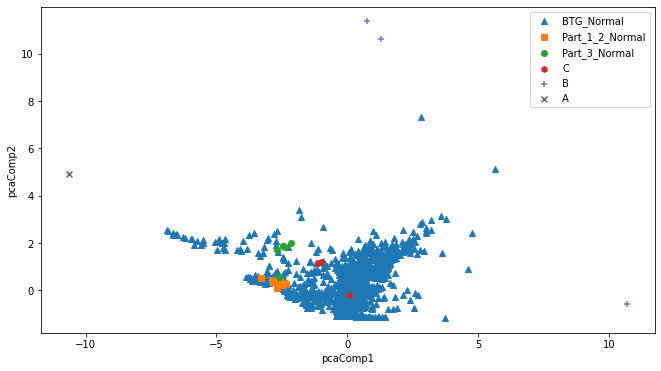

In [29]:
markers = ['^', 's', 'o', 'h', '+', 'x']
tags = ['BTG_Normal', 'Part_1_2_Normal', 'Part_3_Normal', attacks[0], attacks[1], attacks[2]]

plt.figure(figsize=(11, 6))

for i, marker in enumerate(markers):
    x_axis = NormalUserAndGenPCA_DF[NormalUserAndGenPCA_DF['tag']==tags[i]]['pcaComp1']
    y_axis = NormalUserAndGenPCA_DF[NormalUserAndGenPCA_DF['tag']==tags[i]]['pcaComp2']
    plt.scatter(x_axis, y_axis, marker=marker,label=tags[i])
    
plt.legend()
plt.xlabel('pcaComp1')
plt.ylabel('pcaComp2')
plt.show()

In [30]:
NormalUserAndGen = None
NormalUserAndGenTag = []
P0003Persons = ['P00007', 'P00008', 'P00009', 'P00014', 'P00015', 'P00017']
firstSetFlag = True
for user in NormalUserStatic:
    if firstSetFlag:
        NormalUserAndGen = np.reshape(NormalUserStatic[user]['means'], (1,4))
        firstSetFlag = False
        
    else:
        newArray = np.reshape(NormalUserStatic[user]['means'], (1,4))
        NormalUserAndGen = np.append(NormalUserAndGen, newArray, axis=0)
        
    NormalUserAndGenTag.append('BTG_Normal')
        
        
for user in GenUserStatic:
    newArray = np.reshape(GenUserStatic[user]['means'], (1,4))
    NormalUserAndGen = np.append(NormalUserAndGen, newArray, axis=0)
    if not user in  P0003Persons:
        NormalUserAndGenTag.append('Part_1_2_Normal')
    else:
        NormalUserAndGenTag.append('Part_3_Normal')

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(NormalUserAndGen)
NormalUserAndGenPCA = pca.transform(NormalUserAndGen)

pcaColumns = ['pcaComp1', 'pcaComp2']
NormalUserAndGenPCA_DF = pd.DataFrame(NormalUserAndGenPCA, columns = pcaColumns)

NormalUserAndGenPCA_DF['tag'] = NormalUserAndGenTag

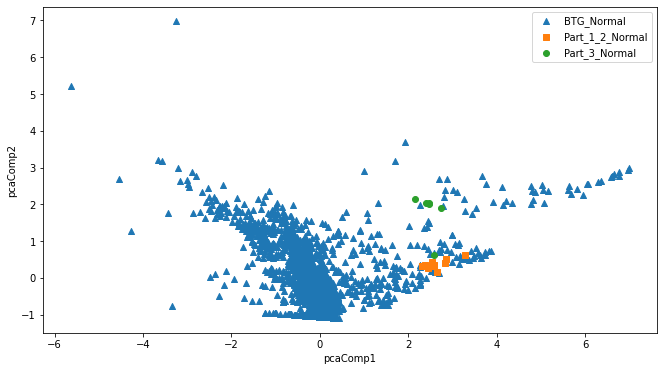

In [32]:
markers = ['^', 's', 'o']
tags = ['BTG_Normal', 'Part_1_2_Normal', 'Part_3_Normal']

plt.figure(figsize=(11, 6))

for i, marker in enumerate(markers):
    x_axis = NormalUserAndGenPCA_DF[NormalUserAndGenPCA_DF['tag']==tags[i]]['pcaComp1']
    y_axis = NormalUserAndGenPCA_DF[NormalUserAndGenPCA_DF['tag']==tags[i]]['pcaComp2']
    plt.scatter(x_axis, y_axis, marker=marker,label=tags[i])
    
plt.legend()
plt.xlabel('pcaComp1')
plt.ylabel('pcaComp2')
plt.show()

In [24]:
import csv
import datetime
from itertools import islice


datasetDir = 'FileLogGenerator\\'
GenTimeFormat = '%m/%d/%Y %H:%M:%S.%f'

f = open(datasetDir+'fileLog2.csv', 'r',encoding='utf-8')
fileData = csv.reader(f)

headers = next(fileData, None)
print(headers)

GenUserActsAdded = {}
count = 0
for row in fileData:
    if not row[4]:
        
        actTime = row[1]
        act = row[2]
        user = row[5]
        toWho = row[15]
        fileID = row[8]
        
        knownFileRank = ''
        if row[12]:
            knownFileRank = row[12]

        userAct = {}
        userAct['actTime'] = actTime
        userAct['act'] = act
        userAct['fileID'] = fileID
        userAct['knownFileRank'] = knownFileRank

        if user in GenUserActsAdded:
            GenUserActsAdded[user].append(userAct)

        else:
            GenUserActsAdded[user] = [userAct]
            
        if act == 'fileSend':
            plusUserAct = {}
            plusUserAct['actTime'] = actTime
            plusUserAct['act'] = 'fileReceive'
            plusUserAct['fileID'] = fileID
            plusUserAct['knownFileRank'] = knownFileRank
            
            if toWho in GenUserActsAdded:
                GenUserActsAdded[toWho].append(plusUserAct)

            else:
                GenUserActsAdded[toWho] = [plusUserAct]

        count += 1
        if count % 100000 == 0:
            print(count)
            
f.close()       
f = open(datasetDir+'fileLog2.csv', 'r',encoding='utf-8')
fileData = csv.reader(f)

headers = next(fileData, None)
print(headers)
            
GenUserAttackActsAdded = {}
ReciveFirstInActs = {}
count = 0
for row in fileData:
    if row[4]:
        AttackSet = row[4][0]
        if not AttackSet in GenUserAttackActsAdded:
            GenUserAttackActsAdded[AttackSet] = {}
            ReciveFirstInActs[AttackSet] = {}
            
        actTime = row[1]
        act = row[2]
        user = row[5]
        toWho = row[15]
        fileID = row[8]
        
        knownFileRank = ''
        if row[12]:
            knownFileRank = row[12]

        userAct = {}
        userAct['actTime'] = actTime
        userAct['act'] = act
        userAct['fileID'] = fileID
        userAct['knownFileRank'] = knownFileRank

        if user in GenUserAttackActsAdded[AttackSet]:
            GenUserAttackActsAdded[AttackSet][user].append(userAct)

        else:
            if user in ReciveFirstInActs[AttackSet]:
                GenUserAttackActsAdded[AttackSet][user] = ReciveFirstInActs[AttackSet][user]
                
            else:
                GenUserAttackActsAdded[AttackSet][user] = []
            
            GenUserAttackActsAdded[AttackSet][user].append(userAct)
            
        if act == 'fileSend':
            plusUserAct = {}
            plusUserAct['actTime'] = actTime
            plusUserAct['act'] = 'fileReceive'
            plusUserAct['fileID'] = fileID
            plusUserAct['knownFileRank'] = knownFileRank
            
            if toWho in GenUserAttackActsAdded[AttackSet]:
                GenUserAttackActsAdded[AttackSet][toWho].append(plusUserAct)

            else:
                if toWho in ReciveFirstInActs[AttackSet]:
                    ReciveFirstInActs[AttackSet][toWho].append(plusUserAct)
                    
                else:
                    ReciveFirstInActs[AttackSet][toWho] = [plusUserAct]

        count += 1
        if count % 100000 == 0:
            print(count)

['eventID', 'eventTime', 'actionType', 'ownershipChange', 'maliciousPlayersTag', 'subjectPersonID', 'subjectPersonRank', 'subjectPersonParts', 'objectFileID', 'objectFileName', 'isFileFromLocal', 'objectFileRank', 'objectFileRankAssumption', 'objectFileCreatedTime', 'objectFileLastModifiedTime', 'objectPersonID', 'objectPersonRank', 'objectPersonParts']
['eventID', 'eventTime', 'actionType', 'ownershipChange', 'maliciousPlayersTag', 'subjectPersonID', 'subjectPersonRank', 'subjectPersonParts', 'objectFileID', 'objectFileName', 'isFileFromLocal', 'objectFileRank', 'objectFileRankAssumption', 'objectFileCreatedTime', 'objectFileLastModifiedTime', 'objectPersonID', 'objectPersonRank', 'objectPersonParts']


In [37]:
import math

def genActionsParse(actions, windowTime):
    GenTimeFormat = '%Y-%m-%d %H:%M:%S.%f'
    
    preWindow = []
    userActionInfo = []
    for action in actions:
        cWindow = []
        currentTime = datetime.datetime.strptime(action['actTime'], GenTimeFormat)
        
        for idx in range(len(preWindow)):
            if currentTime - datetime.datetime.strptime(preWindow[idx]['actTime'], GenTimeFormat) <= windowTime:
                cWindow = preWindow[idx:]
                break
                
        cWindow.append(action)
        fileOpenCount = 0
        fileWriteCount = 0
        fileSendCount = 0
        fileReceiveCount = 0
        
        actFileKnownRankNone = 1
        actFileKnownRank1 = 1
        actFileKnownRank2 = 1
        actFileKnownRank3 = 1
        
        for cAcction in cWindow:
            if cAcction['act'] == 'fileRead':
                fileOpenCount += 1
                
            elif cAcction['act'] == 'fileWrite':
                fileWriteCount += 1
                
            elif cAcction['act'] == 'fileSend':
                fileSendCount += 1
                
            elif cAcction['act'] == 'fileReceive':
                fileReceiveCount += 1
                
            if cAcction['knownFileRank'] == '':
                actFileKnownRankNone += 1
                
            elif cAcction['knownFileRank'] == '1':
                actFileKnownRank1 += 1
                
            elif cAcction['knownFileRank'] == '2':
                actFileKnownRank2 += 1
                
            elif cAcction['knownFileRank'] == '3':
                actFileKnownRank3 += 1
                
                
        cWindowInfo = {}
        cWindowInfo['windowTime'] = str(currentTime)
        cWindowInfo['fileOpenCount'] = fileOpenCount
        cWindowInfo['fileWriteCount'] = fileWriteCount
        cWindowInfo['fileSendCount'] = fileSendCount
        cWindowInfo['fileReceiveCount'] = fileReceiveCount
        cWindowInfo['actFileKnownRankNone'] = max(math.log(actFileKnownRankNone), 0.001)
        cWindowInfo['actFileKnownRank1'] = max(math.log(actFileKnownRank1), 0.001)
        cWindowInfo['actFileKnownRank2'] = max(math.log(actFileKnownRank2), 0.001)
        cWindowInfo['actFileKnownRank3'] = max(math.log(actFileKnownRank3), 0.001)
        userActionInfo.append(cWindowInfo)
        
        preWindow = cWindow
        
    return userActionInfo


windowTime = datetime.timedelta(hours=1)

GenUserWindowInfo = {}
for user in GenUserActsAdded:
    GenUserWindowInfo[user] = genActionsParse(GenUserActsAdded[user], windowTime)
    
GenUserAttackWindowInfo = {}
for attack in GenUserAttackActsAdded:
    GenUserAttackWindowInfo[attack] = {}
    for user in GenUserAttackActsAdded[attack]:
        GenUserAttackWindowInfo[attack][user] = genActionsParse(GenUserAttackActsAdded[attack][user], windowTime)

In [38]:
import numpy as np

GenUserStatic = {}
for user in list(GenUserWindowInfo.keys()):
    windowActInfos = []
    for windowInfo in GenUserWindowInfo[user]:
        windowActInfo = []
        windowActInfo.append(windowInfo['fileOpenCount'])
        windowActInfo.append(windowInfo['fileWriteCount'])
        windowActInfo.append(windowInfo['fileSendCount'])
        windowActInfo.append(windowInfo['fileReceiveCount'])
        
        windowActInfos.append(windowActInfo)
        
    GenUserStatic[user] = {}
    GenUserStatic[user]['means'] = np.mean(windowActInfos, axis=0)
    GenUserStatic[user]['vars'] = np.var(windowActInfos, axis=0)
    GenUserStatic[user]['covM'] = np.cov(windowActInfos, rowvar=False)
    

GenUserStaticSplit = {}
countLim = 400
for user in list(GenUserWindowInfo.keys()):
    GenUserStaticSplit[user] = []
    windowActInfos = []
    i = 0
    count = 0
    for windowInfo in GenUserWindowInfo[user]:
        windowActInfo = []
        windowActInfo.append(windowInfo['fileOpenCount'])
        windowActInfo.append(windowInfo['fileWriteCount'])
        windowActInfo.append(windowInfo['fileSendCount'])
        windowActInfo.append(windowInfo['fileReceiveCount'])
        
        windowActInfos.append(windowActInfo)
        count += 1
        
        if count % countLim == 0 and i < 2:
            tempDict = {}
            tempDict['means'] = np.mean(windowActInfos, axis=0)
            tempDict['vars'] = np.var(windowActInfos, axis=0)
            tempDict['covM'] = np.cov(windowActInfos, rowvar=False)
            GenUserStaticSplit[user].append(tempDict)
            
            i += 1
            windowActInfos = []
            
    tempDict = {}
    tempDict['means'] = np.mean(windowActInfos, axis=0)
    tempDict['vars'] = np.var(windowActInfos, axis=0)
    tempDict['covM'] = np.cov(windowActInfos, rowvar=False)
    GenUserStaticSplit[user].append(tempDict)

    

GenUserAttackStatic = {}
for attack in GenUserAttackWindowInfo:
    GenUserAttackStatic[attack] = {}
    for user in list(GenUserAttackWindowInfo[attack].keys()):
        windowActInfos = []
        for windowInfo in GenUserAttackWindowInfo[attack][user]:
            windowActInfo = []
            windowActInfo.append(windowInfo['fileOpenCount'])
            windowActInfo.append(windowInfo['fileWriteCount'])
            windowActInfo.append(windowInfo['fileSendCount'])
            windowActInfo.append(windowInfo['fileReceiveCount'])

            windowActInfos.append(windowActInfo)

        GenUserAttackStatic[attack][user] = {}
        GenUserAttackStatic[attack][user]['means'] = np.mean(windowActInfos, axis=0)
        GenUserAttackStatic[attack][user]['vars'] = np.var(windowActInfos, axis=0)
        GenUserAttackStatic[attack][user]['covM'] = np.cov(windowActInfos, rowvar=False)


GenUserStaticAdded = {}
for user in list(GenUserWindowInfo.keys()):
    windowActInfos = []
    for windowInfo in GenUserWindowInfo[user]:
        windowActInfo = []
        windowActInfo.append(windowInfo['fileOpenCount'])
        windowActInfo.append(windowInfo['fileWriteCount'])
        windowActInfo.append(windowInfo['fileSendCount'])
        windowActInfo.append(windowInfo['fileReceiveCount'])
        windowActInfo.append(windowInfo['actFileKnownRankNone'])
        windowActInfo.append(windowInfo['actFileKnownRank1'])
        windowActInfo.append(windowInfo['actFileKnownRank2'])
        windowActInfo.append(windowInfo['actFileKnownRank3'])
        
        windowActInfos.append(windowActInfo)
        
    GenUserStaticAdded[user] = {}
    GenUserStaticAdded[user]['means'] = np.mean(windowActInfos, axis=0)
    GenUserStaticAdded[user]['vars'] = np.var(windowActInfos, axis=0)
    GenUserStaticAdded[user]['covM'] = np.cov(windowActInfos, rowvar=False)
    

GenUserStaticSplitAdded = {}
countLim = 400
for user in list(GenUserWindowInfo.keys()):
    GenUserStaticSplitAdded[user] = []
    windowActInfos = []
    i = 0
    count = 0
    for windowInfo in GenUserWindowInfo[user]:
        windowActInfo = []
        windowActInfo.append(windowInfo['fileOpenCount'])
        windowActInfo.append(windowInfo['fileWriteCount'])
        windowActInfo.append(windowInfo['fileSendCount'])
        windowActInfo.append(windowInfo['fileReceiveCount'])
        windowActInfo.append(windowInfo['actFileKnownRankNone'])
        windowActInfo.append(windowInfo['actFileKnownRank1'])
        windowActInfo.append(windowInfo['actFileKnownRank2'])
        windowActInfo.append(windowInfo['actFileKnownRank3'])
        
        windowActInfos.append(windowActInfo)
        count += 1
        
        if count % countLim == 0 and i < 2:
            tempDict = {}
            tempDict['means'] = np.mean(windowActInfos, axis=0)
            tempDict['vars'] = np.var(windowActInfos, axis=0)
            tempDict['covM'] = np.cov(windowActInfos, rowvar=False)
            GenUserStaticSplitAdded[user].append(tempDict)
            
            i += 1
            windowActInfos = []
            
    tempDict = {}
    tempDict['means'] = np.mean(windowActInfos, axis=0)
    tempDict['vars'] = np.var(windowActInfos, axis=0)
    tempDict['covM'] = np.cov(windowActInfos, rowvar=False)
    GenUserStaticSplitAdded[user].append(tempDict)
    

GenUserAttackStaticAdded = {}
for attack in GenUserAttackWindowInfo:
    GenUserAttackStaticAdded[attack] = {}
    for user in list(GenUserAttackWindowInfo[attack].keys()):
        windowActInfos = []
        for windowInfo in GenUserAttackWindowInfo[attack][user]:
            windowActInfo = []
            windowActInfo.append(windowInfo['fileOpenCount'])
            windowActInfo.append(windowInfo['fileWriteCount'])
            windowActInfo.append(windowInfo['fileSendCount'])
            windowActInfo.append(windowInfo['fileReceiveCount'])
            windowActInfo.append(windowInfo['actFileKnownRankNone'])
            windowActInfo.append(windowInfo['actFileKnownRank1'])
            windowActInfo.append(windowInfo['actFileKnownRank2'])
            windowActInfo.append(windowInfo['actFileKnownRank3'])

            windowActInfos.append(windowActInfo)

        GenUserAttackStaticAdded[attack][user] = {}
        GenUserAttackStaticAdded[attack][user]['means'] = np.mean(windowActInfos, axis=0)
        GenUserAttackStaticAdded[attack][user]['vars'] = np.var(windowActInfos, axis=0)
        GenUserAttackStaticAdded[attack][user]['covM'] = np.cov(windowActInfos, rowvar=False)

In [39]:
print('normal P, attack Q')
KLdivGenPGenAttackCQ = {}
targetUsers = list(GenUserAttackStatic['C'].keys())

for targetUser in targetUsers:
    meanP = GenUserStatic[targetUser]['means']
    covMP = GenUserStatic[targetUser]['covM']
    
    meanQ = GenUserAttackStatic['C'][targetUser]['means']
    covMQ = GenUserAttackStatic['C'][targetUser]['covM']
    try:
        KLdivGenPGenAttackCQ[targetUser] = kl_mvn(meanP, covMP, meanQ, covMQ)
    except:
        pass
    
print(KLdivGenPGenAttackCQ)

KLdivGenPGenAttackCQAdded = {}
targetUsers = list(GenUserAttackStatic['C'].keys())

for targetUser in targetUsers:
    meanP = GenUserStaticAdded[targetUser]['means']
    covMP = GenUserStaticAdded[targetUser]['covM']
    
    meanQ = GenUserAttackStaticAdded['C'][targetUser]['means']
    covMQ = GenUserAttackStaticAdded['C'][targetUser]['covM']
    try:
        KLdivGenPGenAttackCQAdded[targetUser] = kl_mvn(meanP, covMP, meanQ, covMQ)
    except:
        pass
    
print(KLdivGenPGenAttackCQAdded)

print('attack P, normal Q')
KLdivGenPGenAttackCQ = {}
targetUsers = list(GenUserAttackStatic['C'].keys())

for targetUser in targetUsers:
    meanQ = GenUserStatic[targetUser]['means']
    covMQ = GenUserStatic[targetUser]['covM']
    
    meanP = GenUserAttackStatic['C'][targetUser]['means']
    covMP = GenUserAttackStatic['C'][targetUser]['covM']
    try:
        KLdivGenPGenAttackCQ[targetUser] = kl_mvn(meanP, covMP, meanQ, covMQ)
    except:
        pass
    
print(KLdivGenPGenAttackCQ)

KLdivGenPGenAttackCQAdded = {}
targetUsers = list(GenUserAttackStatic['C'].keys())

for targetUser in targetUsers:
    meanQ = GenUserStaticAdded[targetUser]['means']
    covMQ = GenUserStaticAdded[targetUser]['covM']
    
    meanP = GenUserAttackStaticAdded['C'][targetUser]['means']
    covMP = GenUserAttackStaticAdded['C'][targetUser]['covM']
    try:
        KLdivGenPGenAttackCQAdded[targetUser] = kl_mvn(meanP, covMP, meanQ, covMQ)
    except:
        pass
    
print(KLdivGenPGenAttackCQAdded)


print('split normal P, attack Q')
KLdivGenSplitPGenAttackCQ = {}
targetUsers = list(GenUserAttackStatic['C'].keys())

for targetUser in targetUsers:
    KLdivGenSplitPGenAttackCQ[targetUser] = []
    for GenUserStaticInfo in GenUserStaticSplit[targetUser]:
        meanP = GenUserStaticInfo['means']
        covMP = GenUserStaticInfo['covM']

        meanQ = GenUserAttackStatic['C'][targetUser]['means']
        covMQ = GenUserAttackStatic['C'][targetUser]['covM']
        
        try:
            KLdivGenSplitPGenAttackCQ[targetUser].append(kl_mvn(meanP, covMP, meanQ, covMQ))
        except:
            pass
    
print(KLdivGenSplitPGenAttackCQ)

KLdivGenSplitPGenAttackCQAdded = {}
targetUsers = list(GenUserAttackStatic['C'].keys())

for targetUser in targetUsers:
    KLdivGenSplitPGenAttackCQAdded[targetUser] = []
    for GenUserStaticInfo in GenUserStaticSplitAdded[targetUser]:
        meanP = GenUserStaticInfo['means']
        covMP = GenUserStaticInfo['covM']
    
        meanQ = GenUserAttackStaticAdded['C'][targetUser]['means']
        covMQ = GenUserAttackStaticAdded['C'][targetUser]['covM']
        
        try:
            KLdivGenSplitPGenAttackCQAdded[targetUser].append(kl_mvn(meanP, covMP, meanQ, covMQ))
        except:
            pass
        
print(KLdivGenSplitPGenAttackCQAdded)

normal P, attack Q
{'P00005': 9.095729210050663, 'P00004': 7.520995923530293, 'P00011': 2.856528089660128}
{'P00005': 45.135355955358726, 'P00004': 45.523166244581, 'P00011': 4.174119097904587}
attack P, normal Q
{'P00005': 8.395354455185721, 'P00004': 6.779512722940662, 'P00011': 16.864981915730638}
{'P00005': 2.914706330964273e+30, 'P00004': 8.869239277577247e+30, 'P00011': 19.423203692897502}
split normal P, attack Q
{'P00005': [7.322666519399661, 10.83925170877274, 9.217380861098935], 'P00004': [5.620759093357666, 9.095517995975166, 7.891821094056519], 'P00011': [2.184945997979648, 3.6307486787755128, 2.978985513587264]}
{'P00005': [47.72234123072667, 51.2933744294516, 48.771397179725525], 'P00004': [48.227535317740596, 52.09364439155586, 49.06352243402647], 'P00011': [3.2833807806371347, 5.061560542447296, 4.794720438565864]}
